# Doordash Estimated Time of Arrival 
Mission: Predict the total delivery duration <br>
Meaning: From Customer Placing Order until it delivered

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [247]:
historical_data = pd.read_csv('historical_data.csv')
historical_data.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [248]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Step 1, look at the data
1. Look at satuan (dollar, minutes, second)
2. Understand the Y actual on data set, in this case total delivery time from, actual_delivery_time - created_at because both are time stamp
3. Look at the data description from here we know that

Data Description
1. both onshift, busy dasher and outstanding orders are during created_at
2. estimated_order_place_duration -> Only from doordash until restaurance received 
3. estimated_store_to_consumer_driving_duration -> Only travel time
4. Thus we miss, TIME RESTAURANT PREPARING THE ORDER

We have
1. created_at -> Order placed
2. actual_delivery_time -> Order arrived
3. Y actual = actual_delivery_time - created_at -> (in second) why? because the time value for estimated are also in second
3. estimated_order_place_duration -> From order placed until accepted by store 
4. esimated_store_to_consumer_driving_duration -> From store received order, cooking time and delivery duration

In [249]:
# From the data, created_at and actual_delivery_time are in OBJECT despite the value is datetime
# Dollar value already in int, and all others are in float
# So convert to datetime
historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])

In [250]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

# Feature Creation
Can we create better feature from existing one
1. Target value needs to be defined
2. Onshift and busy dasher are represented as number during order created time but ratio might be more relevant with, higher ratio means longer duration time
3. We can combine both the estimated order place and delivery time as non prepping duration, reducing information from 2 to 1 column

In [251]:
from datetime import datetime
# 1. Defined target value
historical_data['total_delivery_time'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()

# 2. Busy Ratio
historical_data['busy_ratio'] = (historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers'])

# 3. Non Estimated Preparation time
historical_data['estimated_non_prep_duration'] = (historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration'])

In [252]:
historical_data.head(2)
# Why does total_delivery_time is in days 0 days 01:02:59? not in second
# So its in time delta, can it be in second instead

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0


In [253]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

# Data Modelling
1. One hot encode categorical data for regression, because in category 1 and 2 are two separate things, the numerical value of 1 and 2 and its closeness has no meaning to the category itself, thus its better to make each category a true false
2. Check the unique values
3. Categorical value are: store_id, order_protocol, market_id
4. Why not store_primary_category? There is still null values, we have to make it NaN Null first before one hot encode it

In [254]:
historical_data['market_id'].nunique()

6

In [255]:
historical_data['store_id'].nunique()

6743

In [256]:
historical_data['order_protocol'].nunique()

7

Conclusion:
1. We can one hot encode market_id and order_protocol
2. Using get dummies

In [257]:
market_id_dummies = pd.get_dummies(historical_data['market_id'])
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
197423,1,0,0,0,0,0
197424,1,0,0,0,0,0
197425,1,0,0,0,0,0
197426,1,0,0,0,0,0


In [258]:
order_protocol_dummies = pd.get_dummies(historical_data['order_protocol'])
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
197423,0,0,0,1,0,0,0
197424,0,0,0,1,0,0,0
197425,0,0,0,1,0,0,0
197426,1,0,0,0,0,0,0


In [259]:
# Checking if a NaN store_primary_category has a cateogry in another order
historical_data_test = historical_data[historical_data['store_id'] == 5477]
historical_data_test

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,2300.0,1.000000,784.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,1584.0,0.900000,1084.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0,1.142857,1072.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0.750000,735.0
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,3192.0,1.000000,1161.0
10,3.0,2015-02-02 19:22:53,2015-02-02 20:09:19,5477,NaN,4.0,4,4300,4,1200,1500,1.0,1.0,1.0,446,453.0,2786.0,1.000000,899.0


### Conclusion on analysis
NaN store_primary_category might have a category in different order, for example Mexican and Indian for order 1 and 8

### Action
Impute NaN value for each order based on the common category of that store using dictionary <br>
key is store_id, value is the common values

### Trial on getting the store_primary_category for a specific value

In [260]:
historical_data[historical_data['store_id'] == 5477].store_primary_category.mode()

0     indian
1    mexican
Name: store_primary_category, dtype: object

In [261]:
historical_data[historical_data.store_id == 5477].store_primary_category

1     mexican
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8      indian
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
Name: store_primary_category, dtype: object

In [262]:
# 1. Create list of unique stores
unique_store_id = historical_data['store_id'].unique().tolist()

# 2. Create the dictioanry
store_id_and_category = {store_id: historical_data[historical_data['store_id'] == store_id].store_primary_category.mode()
                         for store_id in unique_store_id}

In [263]:
store_id_and_category

{1845: 0    american
 Name: store_primary_category, dtype: object,
 5477: 0     indian
 1    mexican
 Name: store_primary_category, dtype: object,
 2841: 0    italian
 Name: store_primary_category, dtype: object,
 4139: 0    mexican
 Name: store_primary_category, dtype: object,
 5058: 0    italian
 Name: store_primary_category, dtype: object,
 4149: 0    sandwich
 1        thai
 Name: store_primary_category, dtype: object,
 3201: 0    cafe
 Name: store_primary_category, dtype: object,
 5054: 0    italian
 Name: store_primary_category, dtype: object,
 2004: 0    american
 Name: store_primary_category, dtype: object,
 1984: 0    chinese
 Name: store_primary_category, dtype: object,
 4905: 0    mexican
 Name: store_primary_category, dtype: object,
 1698: 0    sandwich
 Name: store_primary_category, dtype: object,
 1936: 0    singaporean
 Name: store_primary_category, dtype: object,
 6015: 0    burger
 Name: store_primary_category, dtype: object,
 976: 0    breakfast
 Name: store_primary_c

In [264]:
def fill_nan(store_id):
    """Return estimated primary store category from dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

historical_data["non_nan_store_primary_category"] = historical_data['store_id'].apply(fill_nan)

In [265]:
# Checking imputation
historical_data[(historical_data['store_id'] == 5477) & (historical_data['store_primary_category'].isnull())].head(2)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration,non_nan_store_primary_category
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.0,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.0,735.0,indian


In [266]:
# one hot encode that column
non_nan_store_primary_category_dummies = pd.get_dummies(historical_data['non_nan_store_primary_category'])
non_nan_store_primary_category_dummies = non_nan_store_primary_category_dummies.add_prefix('category_')
non_nan_store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [268]:
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies, order_protocol_dummies, market_id_dummies], axis = 1)
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,1,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,1,0,0,0,0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0,0,0,0,0,0,1,0,0,0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0,0,0,0,0,0,1,0,0,0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0,0,0,0,0,0,1,0,0,0


In [270]:
# Convert to float for model 
train_df = train_df.astype('float32')
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Check the value if any value is infinite, it will 
Note
1. Axis 0 is rows
2. Axis 1 is columms (thus we concat the dummies with train_df using column, because we want to concat the column)
3. Check infinite value
4. Replace them with NaN for easier removal


In [271]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.098031,0.224335,0.004022,0.000096,0.192663,0.278876,0.118003,0.241095,0.091172,0.073191
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.297521,0.417420,0.063310,0.009809,0.394420,0.448546,0.322467,0.428078,0.288200,0.260173
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [272]:
train_df['busy_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_ratio, dtype: float64

In [273]:
infinite_rows = np.where(np.any(~np.isfinite(train_df), axis=0) == True)
# ~np.isinfinite will NEGATE each column value
# Example 1 become FALSE because its TRUE as finite then we NEGATE it
# Then we filter in np.where using == True
infinite_rows

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [274]:
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

In [275]:
# Sucessfully remove NaN Value and infinite value particularly for Busy Dasher
train_df['busy_ratio'].describe()

count    177070.000000
mean          0.949947
std           0.406551
min         -13.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: busy_ratio, dtype: float64

In [276]:
train_df.shape
# Lots of column, can have detrimental effect

(177070, 100)

# Part 2 Removing Collinearity
1. Collinearity reduces model interpretability (becaused we don't know which feature affecting the outcome if 2 or more have high coefficient)
2. Using heatmap, we can visualize correlation
3. Ordering the correlation value, we can feature engineered highly correlated feature

## 2.1 Heatmap

In [318]:
# Creating correlation heatmap of 100*100
# But we remove the redudant triangle using mask
corr = train_df.corr()

In [319]:
# Creating mask using np ones
# Initially we create 2d array with the same shape as corr matrix

# np.triu allows to create 0 for the lower left triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


<Axes: >

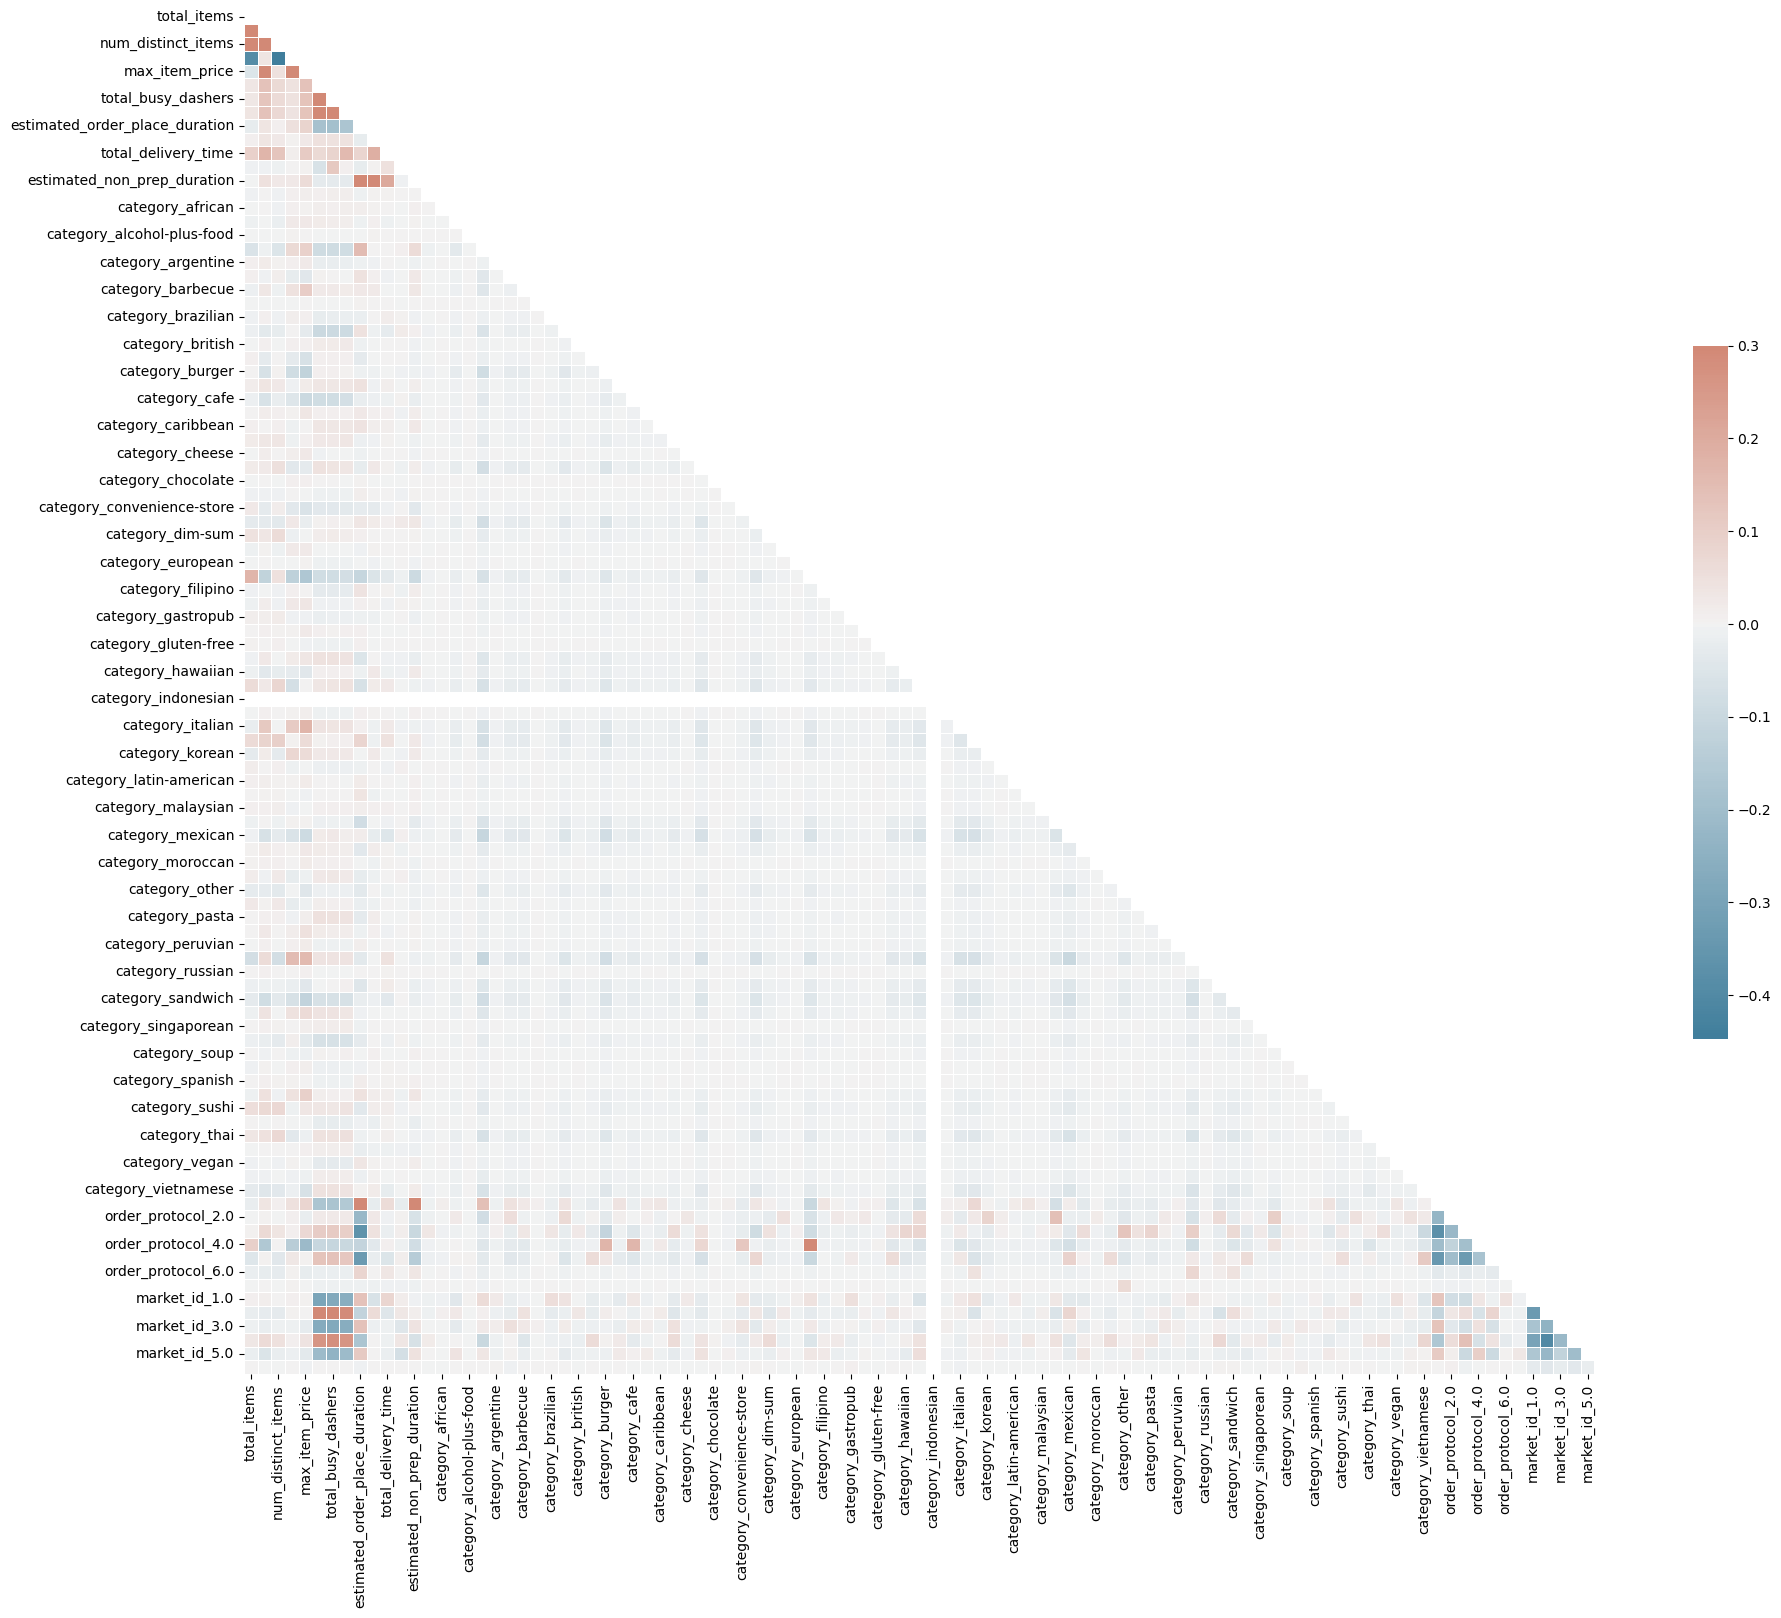

In [325]:
# Plot the heatmap
f, ax = plt.subplots(figsize=(22,18))

# Create colour map, since we have both positive and negative value, we are using diverging pallete
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create heatmap with correlation
sns.heatmap(data=corr, mask=mask, cmap=cmap,
            vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [327]:
# From the map we can see category indonesian has no value
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

## 2.2 Remove correlation through feature engineering
1. Function to
2. Function to get the highest correlation

In [329]:
def get_redundant_pairs(df):
    """Get the lower triangle pairs of attribute, thus removing the redunant pair
      a     b       c
    a a,a
    b b,a   b,b 
    c c,a   c,b     c,c
    """
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [349]:
train_df.corr().abs().unstack()
# Unstack will separate from 100,100 into 10000
# abs will make the negative into positive

total_items    total_items           1.000000
               subtotal              0.557175
               num_distinct_items    0.758146
               min_item_price        0.389277
               max_item_price        0.052845
                                       ...   
market_id_6.0  market_id_2.0         0.040269
               market_id_3.0         0.021746
               market_id_4.0         0.036364
               market_id_5.0         0.020186
               market_id_6.0         1.000000
Length: 10000, dtype: float64

In [350]:
def get_top_abs_correlations(df, n=5):
    """Sore correlation in descending order and return the n highest results"""
    mod_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    sorted_corr = mod_corr.drop(labels=labels_to_drop).sort_values(ascending= False)
    return sorted_corr[0:n]

In [351]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
category_fast                                 order_protocol_4.0             0.489946
num_distinct_items           

## What we can learn from here
1. Both onshift and busy dasher are both highly correlated, additionally we have use busy dasher ratio, thus we can remove both
2. store to consumer and on prep duration are highly correlated, so we can remove the non_prep_duration and maintain the original one
3. Market id are correlated with one another, marker_id_2.0 and marker_id_4.0 and market_id 1 with 2, thus we don't need to combine the dummy variable
4. Removing category indonesian as it has no values

In [394]:
# Removing engineered feature and one_hot_encoding original feature
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])

# Concatenate the dummies without the market_id
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies, order_protocol_dummies], axis = 1)

# Drop values based on the heatmap and correlation results
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "estimated_non_prep_duration", "category_indonesian"])

In [395]:
# Change the value type to float and then remove the infinite value
infinite_rows = np.where(np.any(~np.isfinite(train_df), axis=0) == True)
infinite_rows
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

# Change the datatype
train_df.astype('float32')

train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,...,category_vegan,category_vegetarian,category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,4,3441,4,557,1239,21.0,446,861.0,3779.0,0.424242,...,0,0,0,1,0,0,0,0,0,0
1,1,1900,1,1400,1400,2.0,446,690.0,4024.0,2.000000,...,0,0,0,0,1,0,0,0,0,0
2,1,1900,1,1900,1900,0.0,446,690.0,1781.0,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,6,6900,5,600,1800,2.0,446,289.0,3075.0,1.000000,...,0,0,0,1,0,0,0,0,0,0
4,3,3900,3,1100,1600,9.0,446,650.0,2390.0,1.000000,...,0,0,0,1,0,0,0,0,0,0


In [396]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
category_fast                   order_protocol_4.0    0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duration

## Conclusion
1. We can see that order_protocol are highly correlated so we can just remove it

In [397]:
# Removing engineered feature and one_hot_encoding original feature
train_df = historical_data.drop(columns=["created_at", "actual_delivery_time","market_id", "order_protocol", "store_id","non_nan_store_primary_category","store_primary_category"])

# Concatenate the dummies without the market_id
train_df = pd.concat([train_df, non_nan_store_primary_category_dummies], axis = 1)

# Drop values based on the heatmap and correlation results
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "estimated_non_prep_duration", "category_indonesian"])

# Change the value type to float and then remove the infinite value
train_df.replace([np.inf, -np.inf], np.nan, inplace= True)
train_df.dropna(inplace=True)

# Change the datatype
train_df.astype('float32')

train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,21.0,446,861.0,3779.0,0.424242,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,2.0,446,690.0,4024.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
2,1,1900,1,1900,1900,0.0,446,690.0,1781.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,6,6900,5,600,1800,2.0,446,289.0,3075.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,3,3900,3,1100,1600,9.0,446,650.0,2390.0,1.000000,...,0,0,0,0,0,0,0,0,0,0


In [398]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_delivery_time               0.188418
subtotal                                      total_delivery_time               0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170

### Conclusion
We still have highly correlated item but we can try to reduce it into 1 values 
1. total_items and subtotal item are correlated, so we can combine by subtotal/total_items giving us the average price of items
2. max_item_price and min_item_price is correlated, thus we can subtract max with min to get the price difference
3. We don't remove total_items, we just remove one of the variable that has high correlation <br>
for example sub_total and total, we combine both variable subtotal and total_item, and KEPT TOTAL_ITEMs

In [399]:
# Feature engineering
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df['percent_distinct_item_from_total'] = train_df['num_distinct_items'] / train_df['total_items']

train_df.drop(columns=['subtotal', 'num_distinct_items'], inplace=True)

In [400]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
min_item_price                                avg_price_per_item                  0.860580
max_item_price                                avg_price_per_item                  0.770382
min_item_price                                max_item_price                      0.541241
total_items                                   percent_distinct_item_from_total    0.445751
                                              min_item_price                      0.389277
                                              avg_price_per_item                  0.310759
avg_price_per_item                            percent_distinct_item_from_total    0.226711
category_pizza                                avg_price_per_item                  0.225510
estimated_store_to_consumer_driving_duration  total_delivery_time                 0.188418
max_item_price                                percent_distinct_item_from_total    0.178021
category_fast                                 avg_price_per_item 

In [401]:
train_df['price_range_max_to_min'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

In [402]:
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   percent_distinct_item_from_total    0.445751
                                              price_range_max_to_min              0.333304
                                              avg_price_per_item                  0.310759
avg_price_per_item                            percent_distinct_item_from_total    0.226711
category_pizza                                avg_price_per_item                  0.225510
estimated_store_to_consumer_driving_duration  total_delivery_time                 0.188418
category_fast                                 avg_price_per_item                  0.175950
total_outstanding_orders                      estimated_order_place_duration      0.171049
total_items                                   category_fast                       0.170988
category_italian                              avg_price_per_item                  0.158193
total_outstanding_orders                      total_delivery_time

In [403]:
train_df.shape

(177070, 82)